# Imports

In [1]:
# Import system libraries.
import os
import time
import random
import pathlib
import itertools
from glob import glob
from math import ceil

# Import data handling tools.
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# Import deep learning libraries.
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, SeparableConv2D, GroupNormalization

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Initializations

In [2]:
# Set a fixed random seed for Python, NumPy, and TensorFlow to ensure repeatability.
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Function Definitions

In [3]:
def create_df(data_dir):
    """
    Creates the dataframes from directory.
    """
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

def split_df(df):
    """
    Splits the given DataFrame into train, validation, and test sets.
    The training set receives 80% of the data while the remaining data is equally split between validation and testing.
    """
    # Create train_df and a temporary dummy_df with 80% of the data for training.
    train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=42)

    # Split the remaining data equally into validation and test sets.
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, random_state=42)

    return train_df, valid_df, test_df

In [4]:
def create_gens(df, aug_dict, preprocessing_steps=[]):
    """
    This function creates and returns a generator that yields batches of images and their corresponding masks.
    """
    img_size = (256, 256)
    batch_size = 40

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', 
                                            target_size=img_size, batch_size=batch_size, seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', 
                                           target_size=img_size, batch_size=batch_size, seed=1)

    gen = zip(image_gen, mask_gen)

    for img, msk in gen:
        msk = msk / 255.0  # Normalize the mask to [0,1].
        msk[msk > 0.5] = 1  # Binarize the mask.
        msk[msk <= 0.5] = 0  

        # Apply preprocessing steps.
        for step in preprocessing_steps:
            img, msk = step(img, msk)

        yield (img, msk)

In [5]:
def z_score_norm(img, msk, mean=0.5, std=0.2):
    """
    Applies the z-score normalization.
    """
    img = (img - mean) / std  
    return img, msk

def hist_eq(img, msk):
    """
    Applies the histogram equalization for contrast enhancement.
    """
    img_new = np.zeros_like(img)
    for i in range(img.shape[0]):  # Loop through the batch.
        img_yuv = cv2.cvtColor((img[i] * 255).astype(np.uint8), cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])  # Apply to Y channel.
        img_new[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB) / 255.0
    return img_new, msk

def gaussian_blur(img, msk, kernel_size=(5,5)):
    """
    Applies gaussian blur to reduce the noise.
    """
    img = np.array([cv2.GaussianBlur(i, kernel_size, 0) for i in img])
    return img, msk

def min_max_norm(img, msk):
    """
    Scales pixel values to 0 -- 1 range. Used to speed up the ML training.
    """
    img = img / 255.0
    return img, msk

def sobel_superimpose(img, msk):
    """
    Applies the Sobel filter to each image in the batch to detect edges,
    and then superimposes the detected edges on the original image.
    """
    img_combined = np.empty_like(img)
    
    for i in range(img.shape[0]):
        orig = (img[i] * 255).astype(np.uint8)
        gray = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
        
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel_mag = np.sqrt(sobelx**2 + sobely**2)
        
        # Normalize the gradient magnitude to the range [0, 255].
        if np.max(sobel_mag) > 0:
            sobel_mag = np.uint8(255 * (sobel_mag / np.max(sobel_mag)))
        else:
            sobel_mag = np.zeros_like(sobel_mag, dtype=np.uint8)
        
        # Convert the single channel Sobel result to a 3-channel image.
        sobel_color = cv2.cvtColor(sobel_mag, cv2.COLOR_GRAY2RGB)
        
        # Combine the original image and the Sobel edge image using weighted addition.
        combined = cv2.addWeighted(orig, 0.7, sobel_color, 0.3, 0)
        
        # Normalize the combined image back to the [0,1] range as float32.
        img_combined[i] = combined.astype(np.float32) / 255.0
        
    return img_combined, msk

In [6]:
def unet(input_size=(256, 256, 3)):
    """
    Builds and returns a U-Net model.
    The U-Net architecture is used for image segmentation and is composed of an encoder (downsampling) and a decoder (upsampling) paths.
    """
    
    inputs = Input(input_size)

    # Encoder Path
    conv1 = SeparableConv2D(64, (3, 3), padding="same")(inputs)
    conv1 = Activation("relu")(conv1)
    conv1 = SeparableConv2D(64, (3, 3), padding="same")(conv1)
    conv1 = GroupNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = SeparableConv2D(128, (3, 3), padding="same")(pool1)
    conv2 = Activation("relu")(conv2)
    conv2 = SeparableConv2D(128, (3, 3), padding="same")(conv2)
    conv2 = GroupNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = SeparableConv2D(256, (3, 3), padding="same")(pool2)
    conv3 = Activation("relu")(conv3)
    conv3 = SeparableConv2D(256, (3, 3), padding="same")(conv3)
    conv3 = GroupNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = SeparableConv2D(512, (3, 3), padding="same")(pool3)
    conv4 = Activation("relu")(conv4)
    conv4 = SeparableConv2D(512, (3, 3), padding="same")(conv4)
    conv4 = GroupNormalization()(conv4)
    conv4 = Activation("relu")(conv4)

    # Decoder Path
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = SeparableConv2D(256, (3, 3), padding="same")(up5)
    conv5 = Activation("relu")(conv5)
    conv5 = SeparableConv2D(256, (3, 3), padding="same")(conv5)
    conv5 = GroupNormalization()(conv5)
    conv5 = Activation("relu")(conv5)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = SeparableConv2D(128, (3, 3), padding="same")(up6)
    conv6 = Activation("relu")(conv6)
    conv6 = SeparableConv2D(128, (3, 3), padding="same")(conv6)
    conv6 = GroupNormalization()(conv6)
    conv6 = Activation("relu")(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = SeparableConv2D(64, (3, 3), padding="same")(up7)
    conv7 = Activation("relu")(conv7)
    conv7 = SeparableConv2D(64, (3, 3), padding="same")(conv7)
    conv7 = GroupNormalization()(conv7)
    conv7 = Activation("relu")(conv7)

    outputs = SeparableConv2D(1, (1, 1), activation="sigmoid")(conv7)

    return Model(inputs, outputs)

In [7]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Computes the dice coefficients.
    """
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=1):
    """
    Computes the dice loss.
    """
    return -dice_coef(y_true, y_pred, smooth)

def iou_coef(y_true, y_pred, smooth=1):
    """
    Computes the IoU coefficients.
    """
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [8]:
def show_images(images, masks):
    """
    Prints the images and masks.
    """
    plt.figure(figsize=(12, 12))

    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]

        # Read image and convert it to RGB scale.
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read mask.
        mask = cv2.imread(mask_path)

        # Show image and mask.
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load and Set Up

In [ ]:
# This is the data path for kaggle! Change this to data's source when running locally.
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

print(f"Training set contains {len(train_df)} items.")
print(f"Validation set contains {len(valid_df)} items.")
print(f"Testing set contains {len(test_df)} items.")

# Define augmentation parameters for pre-processing.
tr_aug_dict = dict( rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

preprocessing_pipeline = [z_score_norm ,gaussian_blur, min_max_norm]

train_gen = create_gens(train_df, aug_dict=tr_aug_dict, preprocessing_steps=preprocessing_pipeline)
valid_gen = create_gens(valid_df, aug_dict={}, preprocessing_steps=preprocessing_pipeline)
test_gen  = create_gens(test_df,  aug_dict={}, preprocessing_steps=preprocessing_pipeline)

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

Training set contains 3143 items.
Validation set contains 393 items.
Testing set contains 393 items.


# Create Model

In [10]:
# Define the ML model.
model = unet()

model.compile(optimizer=AdamW(learning_rate=0.0005), loss=[dice_loss], metrics=['accuracy', dice_coef, iou_coef])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 256, 256, 64)   │            283 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ separable_conv2d[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 256, 256, 64)   │          4,736 │ activation[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization       │ (None, 256, 256, 64)   │            128 │ separable_conv2d_1[0]… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ group_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 128, 128, 128)  │          8,896 │ max_pooling2d[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ separable_conv2d_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 128, 128, 128)  │         17,664 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_1     │ (None, 128, 128, 128)  │            256 │ separable_conv2d_3[0]… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ group_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_4        │ (None, 64, 64, 256)    │         34,176 │ max_pooling2d_1[0][0]  │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 64, 64, 256)    │              0 │ separable_conv2d_4[0]… │
├──────────────────────

 Total params: 1,497,564 (5.71 MB)

 Trainable params: 1,497,564 (5.71 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

Magic happens here.

In [11]:
epochs = 120
batch_size = 120

# Callbacks monitor training and set up parameters.
callbacks = [
    ModelCheckpoint('unet.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=ceil(len(valid_df) / batch_size),
)

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6609 - dice_coef: 0.0207 - iou_coef: 0.0105 - loss: -0.0207Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02815, saving model to unet.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6604 - dice_coef: 0.0208 - iou_coef: 0.0105 - loss: -0.0208 - val_accuracy: 0.7015 - val_dice_coef: 0.0282 - val_iou_coef: 0.0143 - val_loss: -0.0282 - learning_rate: 5.0000e-04
Epoch 2/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7537 - dice_coef: 0.0369 - iou_coef: 0.0188 - loss: -0.0369
Epoch 2: val_loss improved from -0.02815 to -0.04989, saving model to unet.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7562 - dice_coef: 0.0371 - iou_coef: 0.0189 - loss: -0.0371 - val_accuracy: 0.9439 - val_dice_coef: 0.0499 - val_iou_coef: 0.0256 - val_loss: -0.0499 - learning_

# Evaluate the Model

In [12]:
# Batching metadata.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# Print these out for posterity.
print(f"Test length = {ts_length} | test batch size = {test_batch_size} | test steps = {test_steps}")
print()

# Evaluate the model.
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

Test length = 393 | test batch size = 3 | test steps = 131

131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 766ms/step - accuracy: 0.9979 - dice_coef: 0.8905 - iou_coef: 0.8035 - loss: -0.8902
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 198ms/step - accuracy: 0.9974 - dice_coef: 0.8606 - iou_coef: 0.7569 - loss: -0.8607
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.9974 - dice_coef: 0.8807 - iou_coef: 0.7879 - loss: -0.8806


# Report the Stats

In [13]:
# Print out evaluation stats.
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train Dice: ", train_score[2])
print("Train IoU: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid Dice: ", valid_score[2])
print("Valid IoU: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test Dice: ", test_score[2])
print("Test IoU: ", test_score[3])

Train Loss:  -0.8915397524833679
Train Accuracy:  0.9978602528572083
Train Dice:  0.8916611075401306
Train IoU:  0.8054633140563965
--------------------
Valid Loss:  -0.8621183633804321
Valid Accuracy:  0.9974498152732849
Valid Dice:  0.8622248768806458
Valid IoU:  0.759178102016449
--------------------
Test Loss:  -0.8801500201225281
Test Accuracy:  0.9974368214607239
Test Dice:  0.880187451839447
Test IoU:  0.7871448993682861


# Context Display

Images for the report below.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


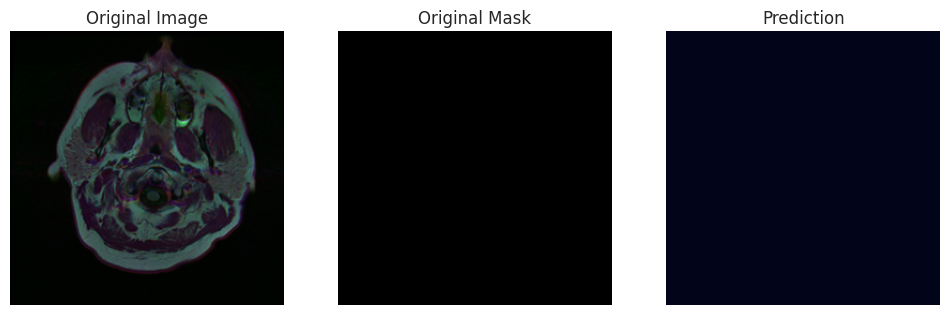

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


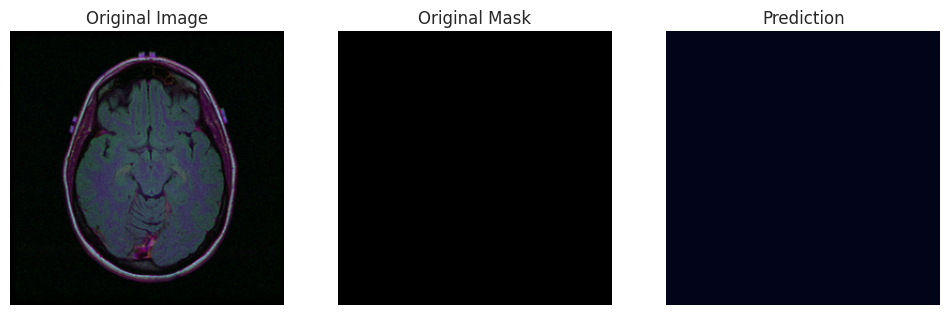

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


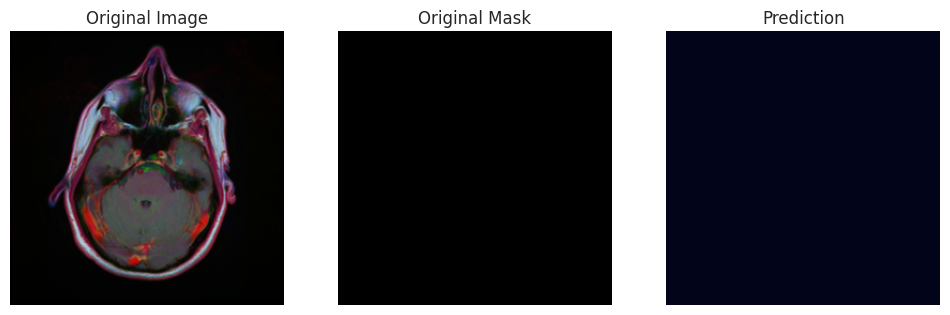

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


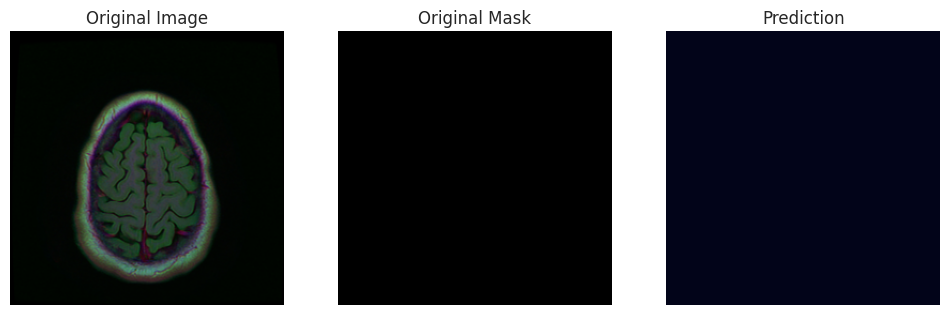

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


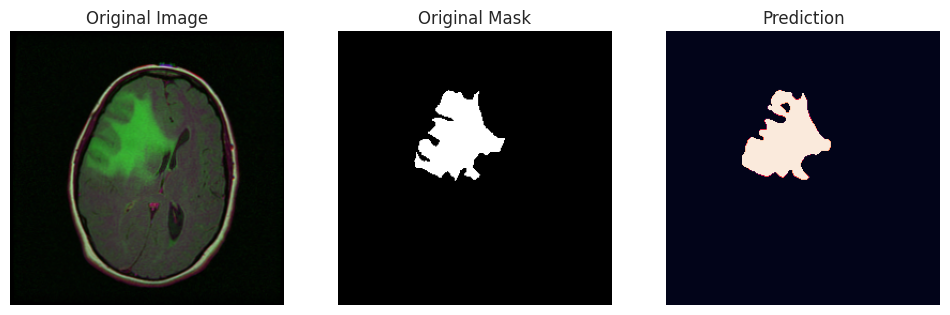

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


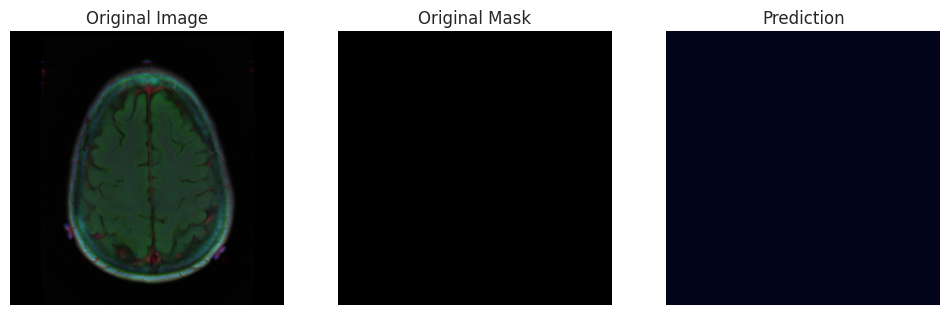

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


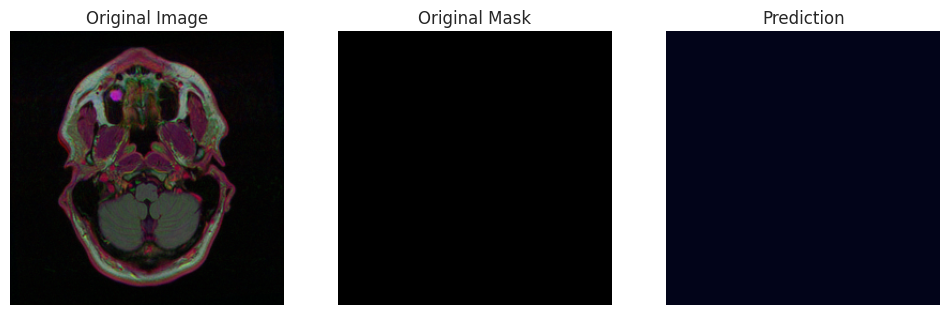

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


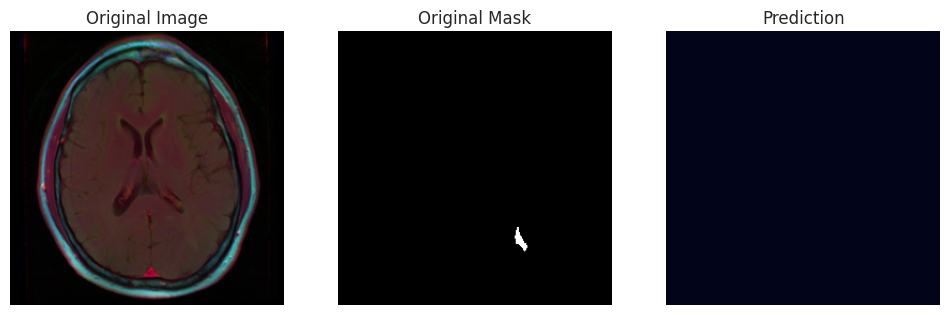

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


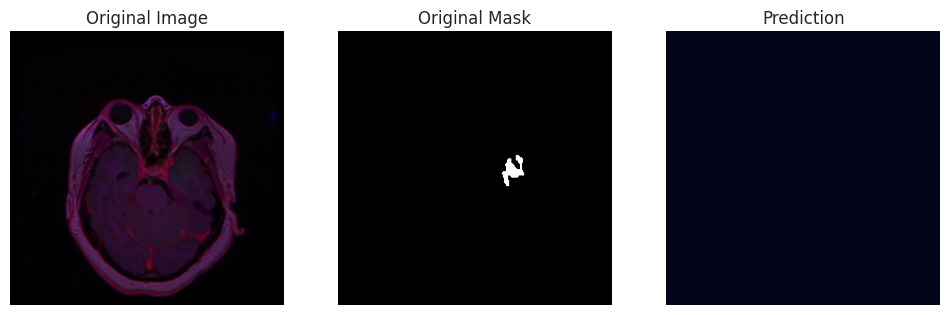

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


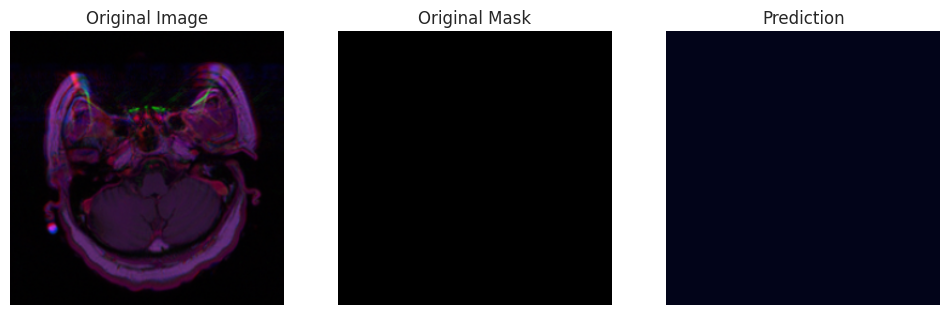

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


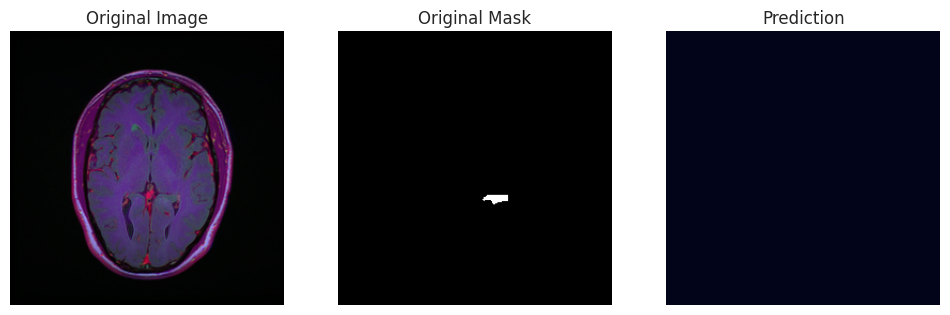

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


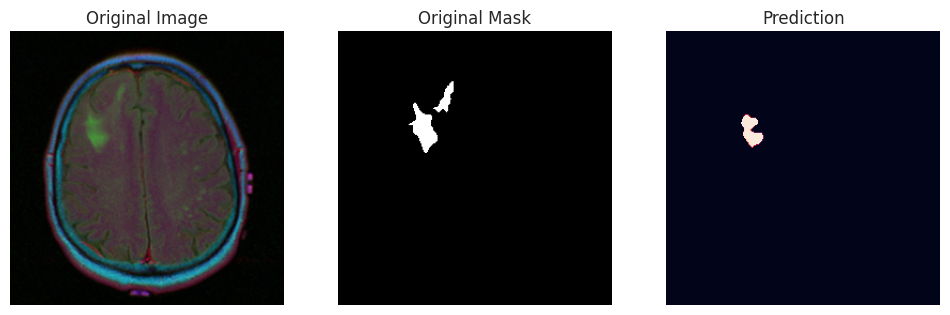

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


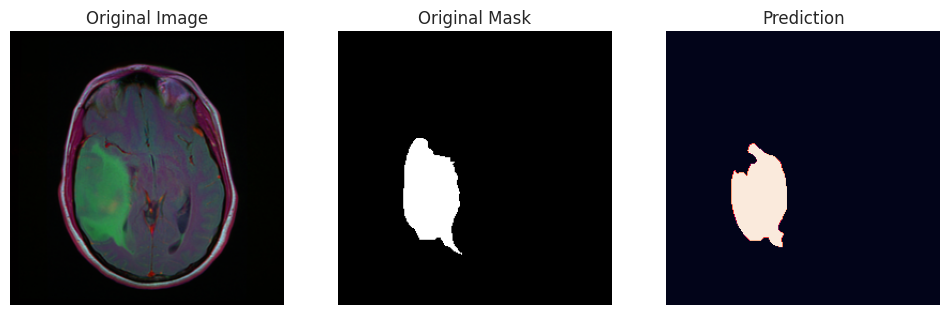

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


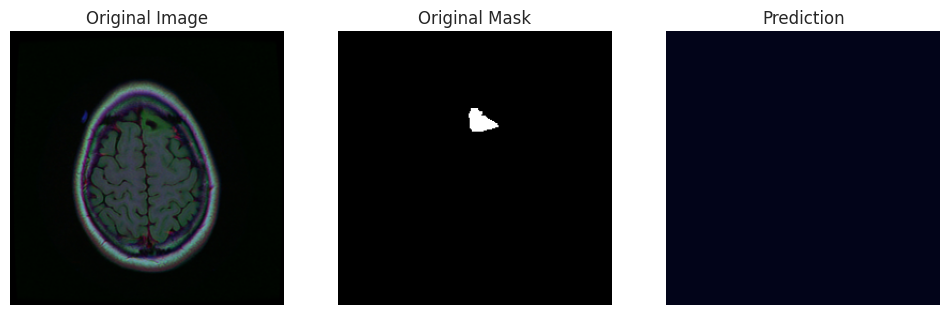

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


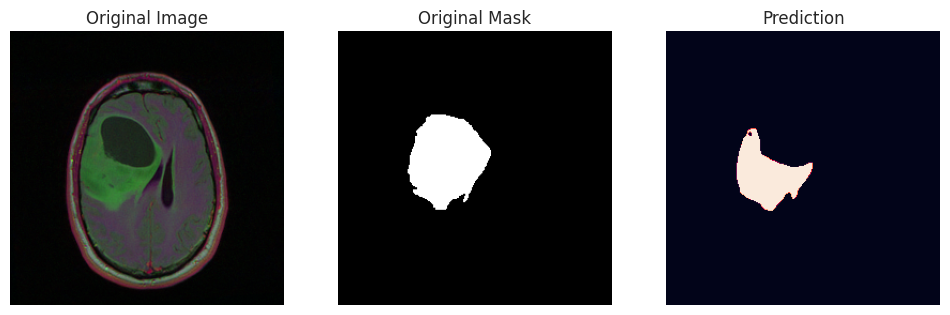

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


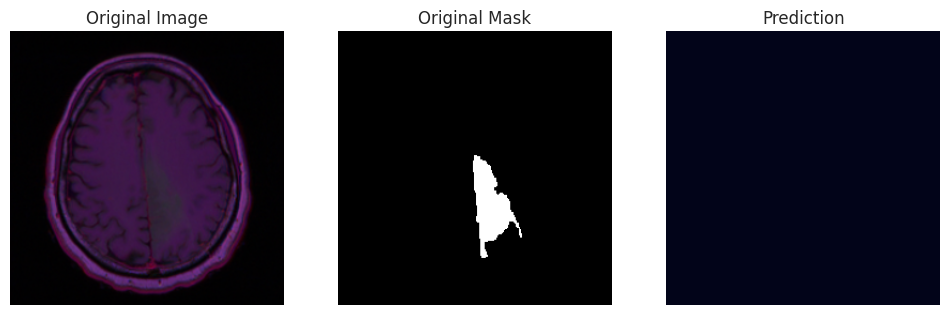

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


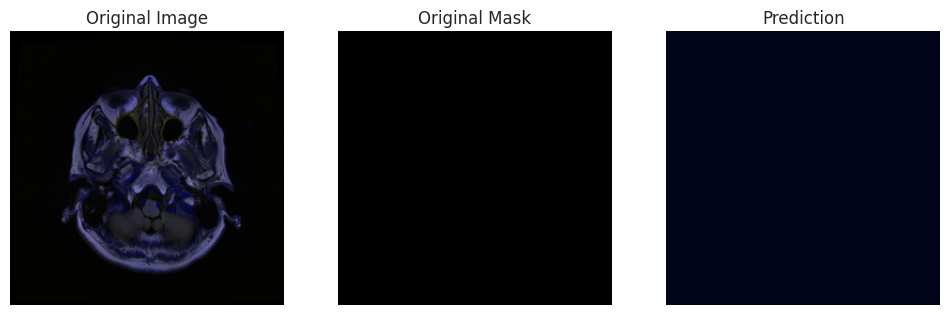

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


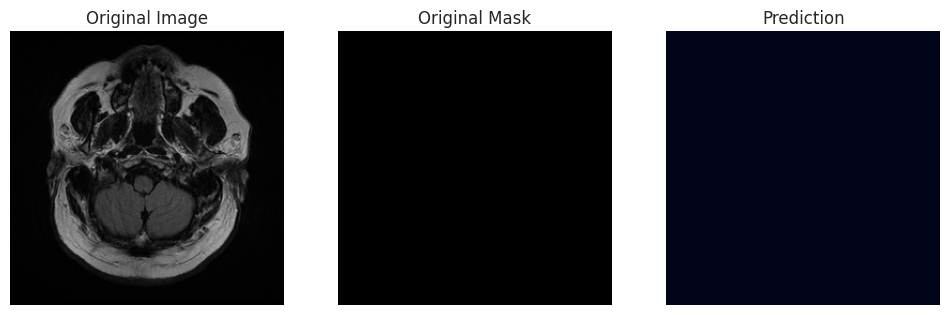

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


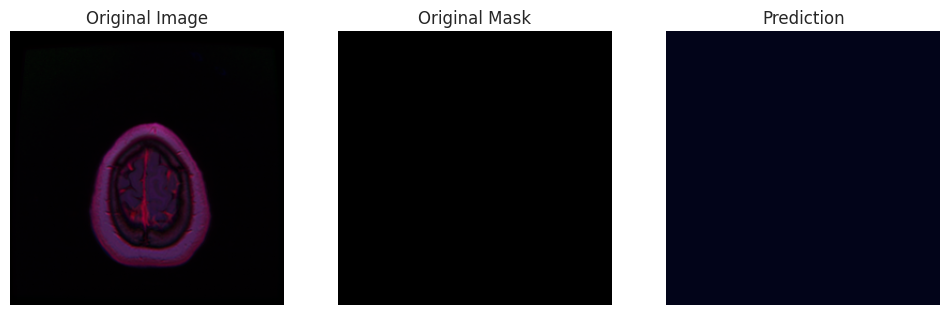

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


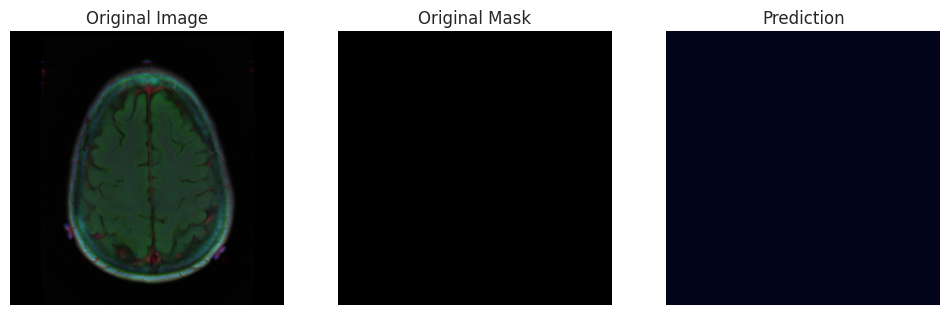

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


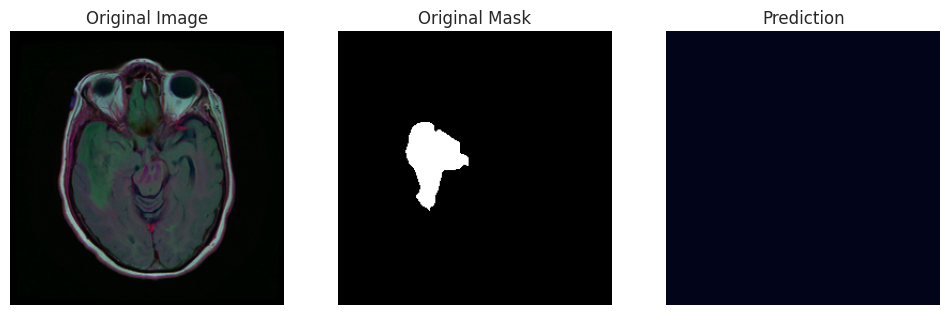

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


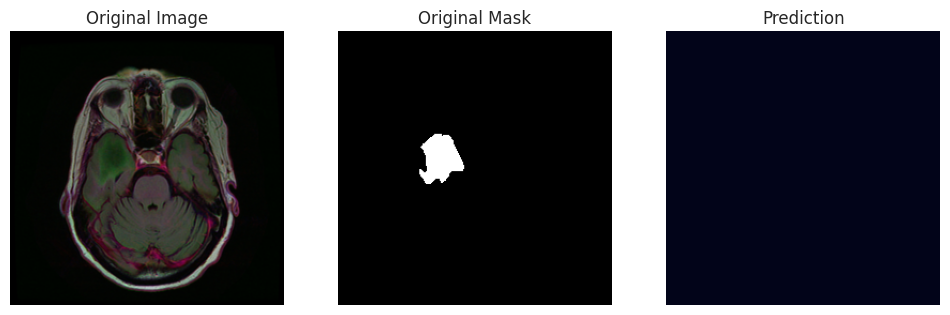

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


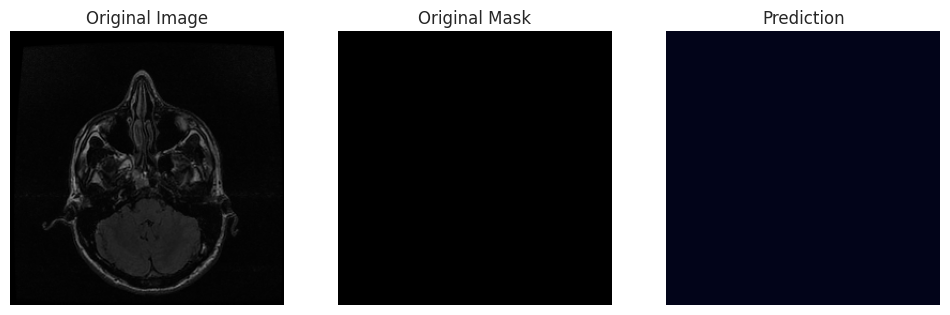

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


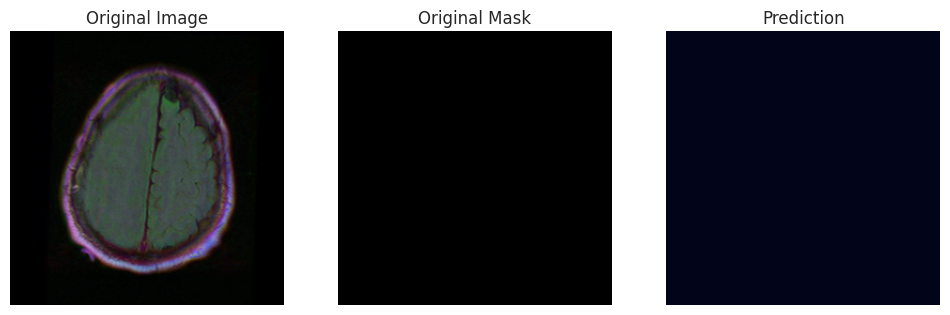

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


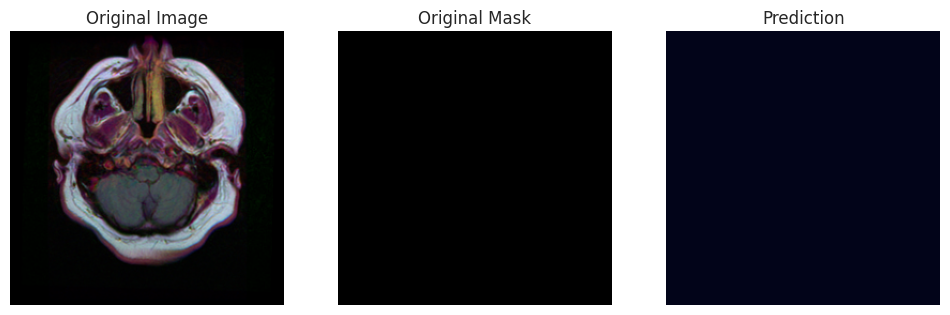

In [15]:
# Display random 25 results.
for _ in range(25):
    index = np.random.randint(0, len(test_df))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()